# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [2]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = '/content/classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [3]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [4]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers (Linear, BatchNorm1d, Dropout, etc.)
        # self....
        self.net = nn.Sequential (
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        # TODO: implement forward pass
        return self.net(x)


In [5]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
model = DNN_Reg4().to(device)
# TODO: loss_fn = ...
loss_fn = nn.MSELoss()
# TODO: optimizer = ...
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

# model = DNN_Reg4(...).to(device)
# loss_fn = ...
# optimizer = ...


In [7]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: forward pass
            pred = model(xb)
            # TODO: compute loss
            loss = loss_fn(pred, yb)
            # TODO: backward
            loss.backward()
            # TODO: optimizer step
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}: {total/n}")
            pass

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1, epochs=EPOCHS)

Epoch 1: 0.7681497274334325
Epoch 500: 0.1013632010342164
Epoch 1000: 0.10160271338888274


In [8]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.9226    0.7366    0.8192      2377
           C     1.0000    0.9169    0.9567      2263
           B     0.9675    0.9529    0.9601      3057
           A     0.9680    0.9711    0.9695      3144

   micro avg     0.9659    0.9032    0.9335     10841
   macro avg     0.9645    0.8944    0.9264     10841
weighted avg     0.9646    0.9032    0.9312     10841
 samples avg     0.6628    0.6386    0.6451     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2978  147]
 [ 626 1751]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 188 2075]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2347   98]
 [ 144 2913]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2257  101]
 [  91 3053]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.9132    0.7223    0.8066      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

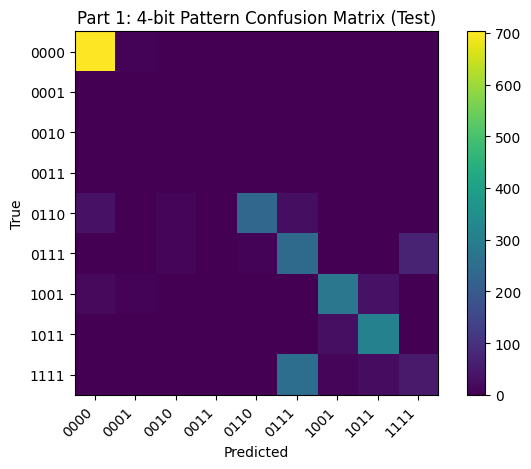

[[703   6   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 34   0   9   0 232  26   0   0   0]
 [  0   0   9   0   7 244   0   0  69]
 [ 17   8   0   0   0   0 280  34   0]
 [  1   0   1   1   0   0  28 309   0]
 [  0   0   0   0   2 253   9  24  52]]


In [9]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [10]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [13]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        # TODO: forward pass returning logits (N,4)
        return self.net(x)


In [14]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
model = DNN_MultiLabel4().to(device)
# TODO: loss_fn = ...
loss_fn = nn.BCEWithLogitsLoss()
# TODO: optimizer = ...
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [15]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}: {total/n}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model, train_loader_2, epochs=EPOCHS)

Epoch 1: 0.7016498799629101
Epoch 500: 0.21506229869585305
Epoch 1000: 0.2138627038808876


In [16]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.7852    0.9306    0.8518      2377
           C     1.0000    0.9205    0.9586      2263
           B     0.9983    0.9372    0.9668      3057
           A     0.9955    0.9838    0.9896      3144

   micro avg     0.9426    0.9458    0.9442     10841
   macro avg     0.9447    0.9430    0.9417     10841
weighted avg     0.9511    0.9458    0.9465     10841
 samples avg     0.6569    0.6635    0.6559     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2520  605]
 [ 165 2212]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 180 2083]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2440    5]
 [ 192 2865]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2344   14]
 [  51 3093]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.7887    0.9156    0.8474      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

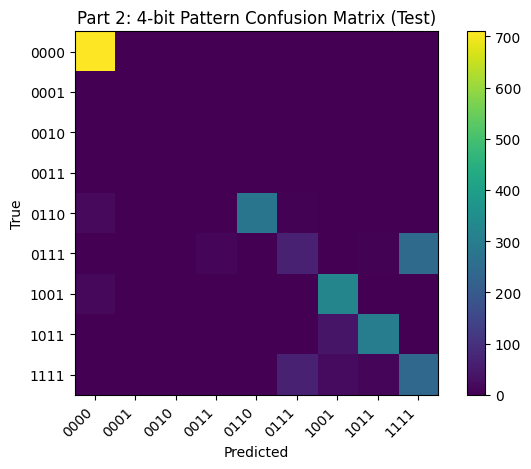

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 18   0   2   0 277   4   0   0   0]
 [  0   0   0  11   2  66   0   5 245]
 [ 16   0   0   0   0   0 323   0   0]
 [  1   1   0   0   0   0  40 298   0]
 [  0   0   0   0   2  66  20  11 241]]


In [17]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [19]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [20]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        return self.net(x)


In [21]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
model = DNN_MultiClass6().to(device)
# TODO: loss_fn = ...
loss_fn = nn.CrossEntropyLoss()
# TODO: optimizer = ...
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [23]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}: {total/n}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model, train_loader_3, epochs=EPOCHS)

Epoch 1: 0.6634516269672744
Epoch 500: 0.6258827027560407
Epoch 1000: 0.6265075201989954



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9329    0.9994    0.9650      1655
          LG     0.9011    0.8646    0.8824       790
          LL     0.9140    0.9374    0.9256       703
         LLG     0.8880    0.9484    0.9172       794
         LLL     0.5754    0.3533    0.4378       767
        LLLG     0.5113    0.6003    0.5522       793

    accuracy                         0.8172      5502
   macro avg     0.7871    0.7839    0.7800      5502
weighted avg     0.8088    0.8172    0.8082      5502



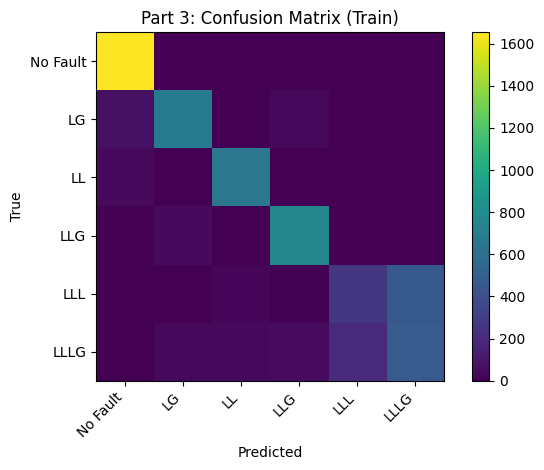


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9330    1.0000    0.9653       710
          LG     0.9133    0.8702    0.8912       339
          LL     0.9153    0.9336    0.9243       301
         LLG     0.8978    0.9559    0.9259       340
         LLL     0.4975    0.2979    0.3726       329
        LLLG     0.4817    0.5794    0.5260       340

    accuracy                         0.8080      2359
   macro avg     0.7731    0.7728    0.7676      2359
weighted avg     0.7970    0.8080    0.7978      2359



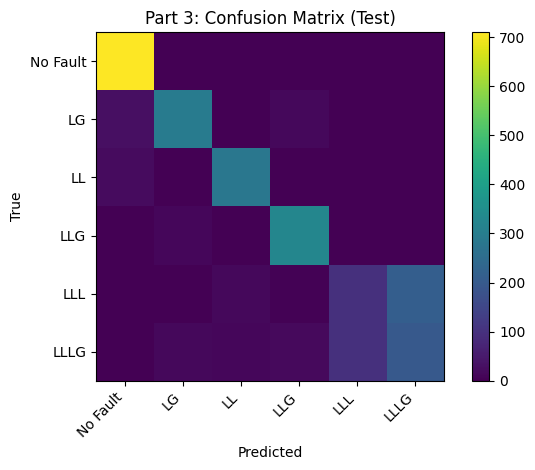

In [24]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: Part 3 with the multi-class classification approach fits the dataset best because the fault labels naturally fall into a small number of discrete categories. As mentioned in the Lecture 9 slides, cross entropy loss is specifically meant for classification tasks and is better than MSE when predicting categorical outputs. This makes Part 3 the best formulation for this multi-class fault classification problem.
- Q2: Yes, in parts 1 and 2 there were cases where the predicted outputs did not correspond cleanly to 1 fault category. This happens becasue each bit is predicted independently so the model is not constrained to produce only valid fault combinations. It suggests that even though the accuracy can be high, this bit based approach does not fully capture the categorical nature of the fault labels.
- Q3: From the confusion matrices, LLL and LLLG were the hardest to predict as they had the lowest f1 scores and recall scores on the test set (in part 3). At the bit level, G was the hardest to predict based off the low f1 scores in both part 1 and 2. So 1 reason that LLL and LLLG were difficult to identify could be because it's hard to identfiy ground faults from the provided current and voltage data (in other words, they have similar feature representations making it harder to classify).


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [36]:
#creating binary tables and the train test split
y_binary = (y_fault != 0).astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_binary
)

print("Train size:", X_train_b.shape[0])
print("Test size :", X_test_b.shape[0])

Train size: 5502
Test size : 2359


In [37]:
#getting the scaled data and preparing the torch dataset
scaler_b = RobustScaler()
X_train_sb = scaler_b.fit_transform(X_train_b).astype(np.float32)
X_test_sb  = scaler_b.transform(X_test_b).astype(np.float32)

Xtrb = torch.from_numpy(X_train_sb)
Xteb = torch.from_numpy(X_test_sb)

ytrb = torch.from_numpy(y_train_b.astype(np.float32)).view(-1, 1)
yteb = torch.from_numpy(y_test_b.astype(np.float32)).view(-1, 1)

train_loader_b = DataLoader(TensorDataset(Xtrb, ytrb), batch_size=BATCH_SIZE, shuffle=True)

In [39]:
#training the bianary dnn
class DNN_Binary(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, p_drop=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.net(x)

In [40]:
model = DNN_Binary().to(device)
loss_fn= nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [41]:
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs / 2, epochs]:
           print(f"Epoch {ep}: {total/n}")

#train the model
train_part5(model, train_loader_b, epochs=EPOCHS)

Epoch 1: 0.7347509971491774
Epoch 500: 0.07996391441899185
Epoch 1000: 0.10279460375101425


In [42]:
#predicting binary functions using sigmoid function
@torch.no_grad()
def predict_binary(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy().ravel()
    return (probs >= threshold).astype(int)

pred_train = predict_binary(model, X_train_sb)
pred_test  = predict_binary(model, X_test_sb)


=== Part 5 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9583    0.9994    0.9784      1655
       Fault     0.9997    0.9813    0.9904      3847

    accuracy                         0.9867      5502
   macro avg     0.9790    0.9903    0.9844      5502
weighted avg     0.9873    0.9867    0.9868      5502



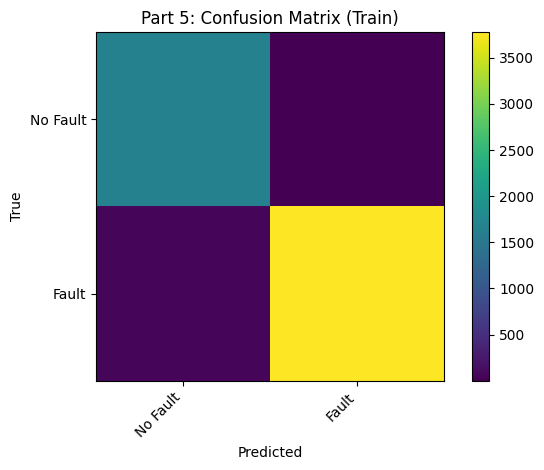


=== Part 5 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9673    1.0000    0.9834       710
       Fault     1.0000    0.9854    0.9927      1649

    accuracy                         0.9898      2359
   macro avg     0.9837    0.9927    0.9880      2359
weighted avg     0.9902    0.9898    0.9899      2359



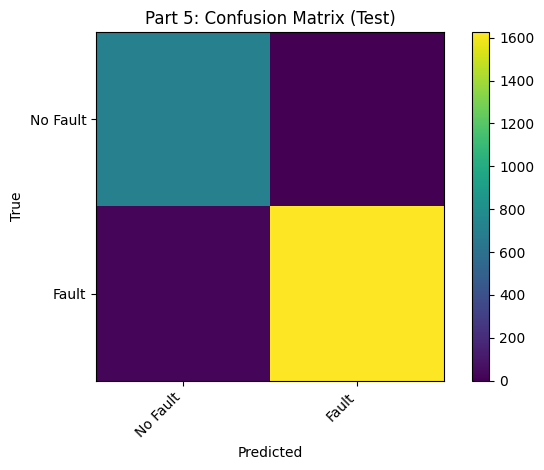

In [43]:
print("\n=== Part 5 | Train ===")
print(classification_report(y_train_b, pred_train, target_names=["No Fault", "Fault"], digits=4))

cm_tr = confusion_matrix(y_train_b, pred_train, labels=[0, 1])
plot_cm(cm_tr, "Part 5: Confusion Matrix (Train)", ["No Fault", "Fault"])

print("\n=== Part 5 | Test ===")
print(classification_report(y_test_b, pred_test,
                            target_names=["No Fault", "Fault"], digits=4))

cm_te = confusion_matrix(y_test_b, pred_test, labels=[0, 1])
plot_cm(cm_te, "Part 5: Confusion Matrix (Test)", ["No Fault", "Fault"])